# Лабораторная работа №7 (Проведение исследований моделями семантической сегментации)

## 1.	Выбор начальных условий

In [ ]:
!pip install segmentation_models_pytorch --quiet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from sklearn.metrics import jaccard_score, f1_score
import cv2
import os
from glob import glob
from tqdm import tqdm

В данной работе будет использоваться датасет Kvasir-SEG. Kvasir-SEG - это набор данных с изображениями полипов желудочно-кишечного тракта в открытом доступе и соответствующими масками сегментации, которые вручную аннотированы врачом и затем проверены опытным гастроэнтерологом.

Модель, решающая задачу семантической сегментации для такого датасета, может применяться в медицинской сфере и быть помощником квалифицированных специалистов в различных исследованиях

Определим параметры обучения и используемое устройство

In [ ]:
class Config:
    DATA_DIR = './kvasir_seg'
    IMG_SIZE = 256
    BATCH_SIZE = 16
    LR = 1e-4
    EPOCHS = 15
    N_CLASSES = 1

# Проверка GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


Определим объект датасета для конкретной решаемой задачи:

In [ ]:
class MedicalDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = [p.replace('images', 'masks') for p in image_paths]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.cvtColor(cv2.imread(self.image_paths[idx]), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        mask = (mask > 0).float()
        return image, mask

Деление датасета на тренировочную и тестовую части в соотношении 1:4

In [ ]:
all_images = sorted(glob(os.path.join(Config.DATA_DIR, 'images', '*.jpg')))
train_size = int(0.8 * len(all_images))
train_files, val_files = all_images[:train_size], all_images[train_size:]

In [ ]:
base_transform = A.Compose([
    A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

train_dataset = MedicalDataset(train_files, base_transform)
val_dataset = MedicalDataset(val_files, base_transform)

train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE)

Визуализируем некоторые примеры изображений датасета

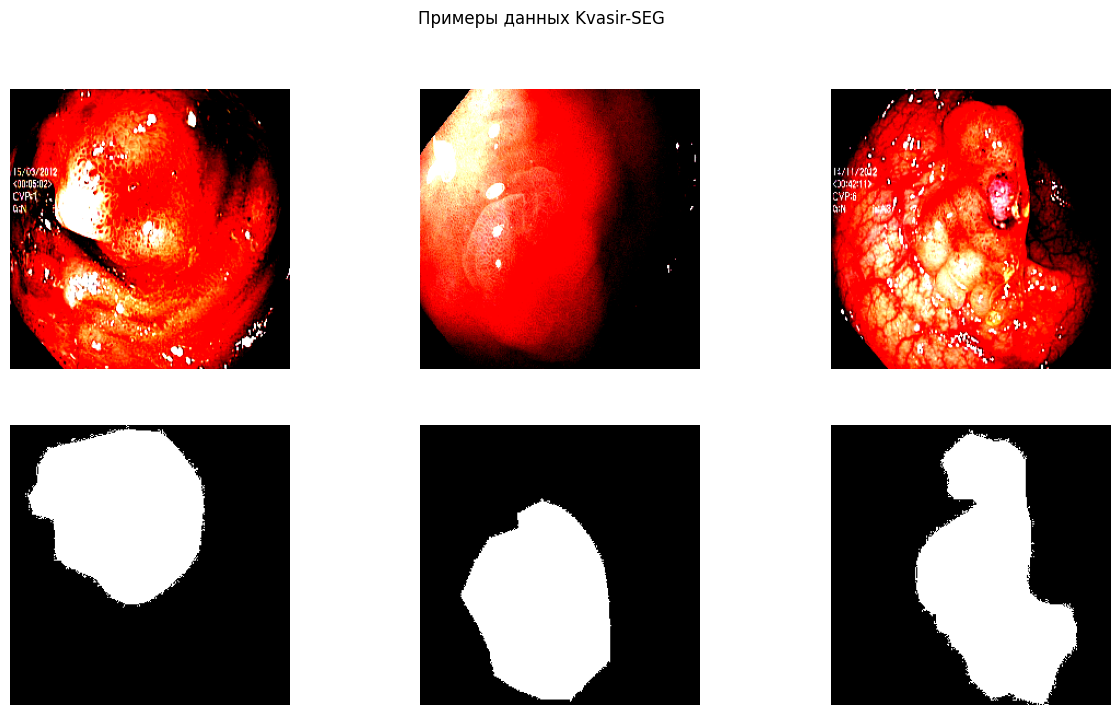

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i in range(3):
    img, mask = train_dataset[i]
    axes[0,i].imshow(img.permute(1,2,0))
    axes[0,i].axis('off')
    axes[1,i].imshow(mask.squeeze(), cmap='gray')
    axes[1,i].axis('off')
plt.suptitle('Примеры данных Kvasir-SEG')
plt.show()

Функция обучения модели. При оценки качества модели будем ориентироваться на метрики IoU (Intersection over Union, Jaccard Index) и Dice Index. IoU оценивает степень пересечения между предсказанной и реальной областями сегментации, а индекс Дайса показывает, насколько хорошо предсказанная маска совпадает с истинной.

In [ ]:
def train_model(model, train_loader, val_loader, epochs):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=Config.LR)
    criterion = nn.BCELoss()

    history = {'loss': [], 'iou': [], 'dice': []}

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for images, masks in tqdm(train_loader):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.squeeze(1), masks)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        model.eval()
        iou_scores, dice_scores = [], []
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                preds = (outputs.squeeze(1) > 0.5).float()

                iou = jaccard_score(masks.cpu().numpy().flatten(),
                                    preds.cpu().numpy().flatten())
                dice = f1_score(masks.cpu().numpy().flatten(),
                               preds.cpu().numpy().flatten())
                iou_scores.append(iou)
                dice_scores.append(dice)

        avg_loss = epoch_loss / len(train_loader)
        avg_iou = np.mean(iou_scores)
        avg_dice = np.mean(dice_scores)

        history['loss'].append(avg_loss)
        history['iou'].append(avg_iou)
        history['dice'].append(avg_dice)

        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Loss: {avg_loss:.4f}, IoU: {avg_iou:.4f}, Dice: {avg_dice:.4f}')

    return history

## 2.	Создание бейзлайна и оценка качества

Проведём сравнения двух библиотечных моделей - UNet и DeepLabV3Plus

In [ ]:
unet = smp.Unet('resnet34', classes=1, activation='sigmoid')
deeplab = smp.DeepLabV3Plus('resnet34', classes=1, activation='sigmoid')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
print('Training U-Net...')
unet_history = train_model(unet, train_loader, val_loader, Config.EPOCHS)

Training U-Net...


100%|██████████| 50/50 [00:21<00:00,  2.34it/s]


Epoch 1/15
Loss: 0.4051, IoU: 0.6410, Dice: 0.7767


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


Epoch 2/15
Loss: 0.2267, IoU: 0.6849, Dice: 0.8063


100%|██████████| 50/50 [00:13<00:00,  3.75it/s]


Epoch 3/15
Loss: 0.1635, IoU: 0.7114, Dice: 0.8267


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


Epoch 4/15
Loss: 0.1315, IoU: 0.7358, Dice: 0.8415


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


Epoch 5/15
Loss: 0.1083, IoU: 0.7567, Dice: 0.8574


100%|██████████| 50/50 [00:15<00:00,  3.29it/s]


Epoch 6/15
Loss: 0.0921, IoU: 0.7420, Dice: 0.8456


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


Epoch 7/15
Loss: 0.0807, IoU: 0.7576, Dice: 0.8558


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


Epoch 8/15
Loss: 0.0695, IoU: 0.7642, Dice: 0.8607


100%|██████████| 50/50 [00:15<00:00,  3.30it/s]


Epoch 9/15
Loss: 0.0624, IoU: 0.7662, Dice: 0.8640


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


Epoch 10/15
Loss: 0.0643, IoU: 0.7268, Dice: 0.8360


100%|██████████| 50/50 [00:14<00:00,  3.57it/s]


Epoch 11/15
Loss: 0.0651, IoU: 0.7539, Dice: 0.8544


100%|██████████| 50/50 [00:13<00:00,  3.61it/s]


Epoch 12/15
Loss: 0.0549, IoU: 0.7758, Dice: 0.8693


100%|██████████| 50/50 [00:13<00:00,  3.58it/s]


Epoch 13/15
Loss: 0.0472, IoU: 0.7616, Dice: 0.8612


100%|██████████| 50/50 [00:13<00:00,  3.60it/s]


Epoch 14/15
Loss: 0.0442, IoU: 0.7789, Dice: 0.8707


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


Epoch 15/15
Loss: 0.0398, IoU: 0.7699, Dice: 0.8646


In [ ]:
print('\nTraining DeepLabV3+...')
deeplab_history = train_model(deeplab, train_loader, val_loader, Config.EPOCHS)


Training DeepLabV3+...


100%|██████████| 50/50 [00:16<00:00,  3.10it/s]


Epoch 1/15
Loss: 0.4448, IoU: 0.6550, Dice: 0.7876


100%|██████████| 50/50 [00:14<00:00,  3.47it/s]


Epoch 2/15
Loss: 0.2206, IoU: 0.6746, Dice: 0.7993


100%|██████████| 50/50 [00:14<00:00,  3.43it/s]


Epoch 3/15
Loss: 0.1547, IoU: 0.7179, Dice: 0.8292


100%|██████████| 50/50 [00:14<00:00,  3.52it/s]


Epoch 4/15
Loss: 0.1229, IoU: 0.7260, Dice: 0.8349


100%|██████████| 50/50 [00:14<00:00,  3.51it/s]


Epoch 5/15
Loss: 0.0990, IoU: 0.7417, Dice: 0.8465


100%|██████████| 50/50 [00:14<00:00,  3.49it/s]


Epoch 6/15
Loss: 0.0852, IoU: 0.7337, Dice: 0.8412


100%|██████████| 50/50 [00:14<00:00,  3.48it/s]


Epoch 7/15
Loss: 0.0727, IoU: 0.7499, Dice: 0.8523


100%|██████████| 50/50 [00:14<00:00,  3.50it/s]


Epoch 8/15
Loss: 0.0663, IoU: 0.7535, Dice: 0.8540


100%|██████████| 50/50 [00:14<00:00,  3.51it/s]


Epoch 9/15
Loss: 0.0591, IoU: 0.7422, Dice: 0.8460


100%|██████████| 50/50 [00:14<00:00,  3.46it/s]


Epoch 10/15
Loss: 0.0528, IoU: 0.7549, Dice: 0.8542


100%|██████████| 50/50 [00:14<00:00,  3.50it/s]


Epoch 11/15
Loss: 0.0469, IoU: 0.7642, Dice: 0.8612


100%|██████████| 50/50 [00:14<00:00,  3.44it/s]


Epoch 12/15
Loss: 0.0433, IoU: 0.7545, Dice: 0.8545


100%|██████████| 50/50 [00:14<00:00,  3.48it/s]


Epoch 13/15
Loss: 0.0404, IoU: 0.7629, Dice: 0.8594


100%|██████████| 50/50 [00:14<00:00,  3.48it/s]


Epoch 14/15
Loss: 0.0362, IoU: 0.7725, Dice: 0.8658


100%|██████████| 50/50 [00:14<00:00,  3.48it/s]


Epoch 15/15
Loss: 0.0340, IoU: 0.7681, Dice: 0.8631


Визуализация результатов:

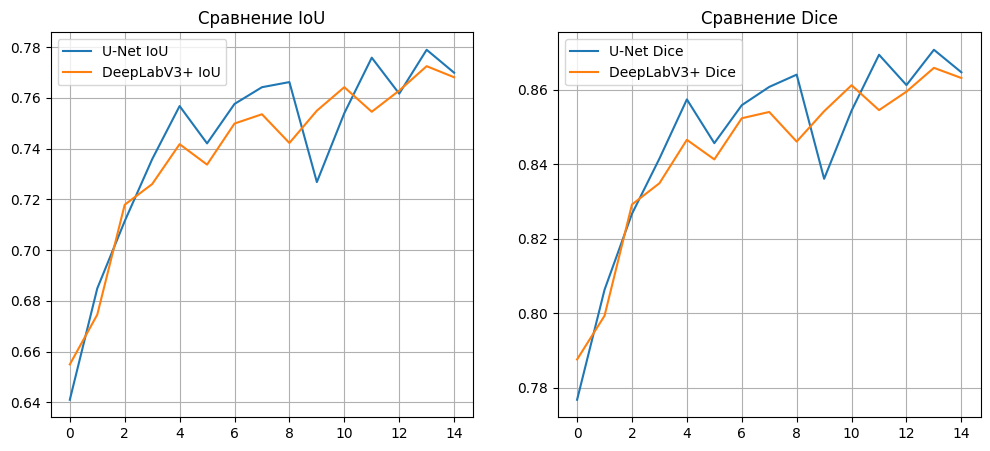

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(unet_history['iou'], label='U-Net IoU')
plt.plot(deeplab_history['iou'], label='DeepLabV3+ IoU')
plt.title('Сравнение IoU')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(unet_history['dice'], label='U-Net Dice')
plt.plot(deeplab_history['dice'], label='DeepLabV3+ Dice')
plt.title('Сравнение Dice')
plt.legend()
plt.grid()
plt.show()

Как можно видеть, модели показали почти одинаковые результаты, однако в среднем UNet оказалась немного лучше

## 3.	Улучшение бейзлайна

Улучшим бейзлайн добавлением аугментаций, а именно вращений, отражений и коррекций яркости изображений.

In [ ]:
aug_transform = A.Compose([
    A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [ ]:
train_dataset_aug = MedicalDataset(train_files, aug_transform)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=Config.BATCH_SIZE, shuffle=True)

Обучение модели на улучшенном бейзлайне

In [ ]:
print('Training U-Net with augmentations...')
unet_aug = smp.Unet('resnet34', classes=1, activation='sigmoid')
unet_aug_history = train_model(unet_aug, train_loader_aug, val_loader, Config.EPOCHS)

Training U-Net with augmentations...


100%|██████████| 50/50 [00:14<00:00,  3.47it/s]


Epoch 1/15
Loss: 0.4900, IoU: 0.6263, Dice: 0.7669


100%|██████████| 50/50 [00:14<00:00,  3.42it/s]


Epoch 2/15
Loss: 0.2828, IoU: 0.6859, Dice: 0.8089


100%|██████████| 50/50 [00:14<00:00,  3.47it/s]


Epoch 3/15
Loss: 0.2145, IoU: 0.7052, Dice: 0.8215


100%|██████████| 50/50 [00:14<00:00,  3.50it/s]


Epoch 4/15
Loss: 0.1698, IoU: 0.7360, Dice: 0.8426


100%|██████████| 50/50 [00:14<00:00,  3.51it/s]


Epoch 5/15
Loss: 0.1470, IoU: 0.7477, Dice: 0.8486


100%|██████████| 50/50 [00:14<00:00,  3.41it/s]


Epoch 6/15
Loss: 0.1316, IoU: 0.7547, Dice: 0.8542


100%|██████████| 50/50 [00:14<00:00,  3.49it/s]


Epoch 7/15
Loss: 0.1213, IoU: 0.7530, Dice: 0.8525


100%|██████████| 50/50 [00:14<00:00,  3.49it/s]


Epoch 8/15
Loss: 0.1093, IoU: 0.7439, Dice: 0.8473


100%|██████████| 50/50 [00:14<00:00,  3.45it/s]


Epoch 9/15
Loss: 0.0986, IoU: 0.7880, Dice: 0.8749


100%|██████████| 50/50 [00:14<00:00,  3.50it/s]


Epoch 10/15
Loss: 0.0935, IoU: 0.7759, Dice: 0.8674


100%|██████████| 50/50 [00:16<00:00,  3.10it/s]


Epoch 11/15
Loss: 0.0889, IoU: 0.7681, Dice: 0.8623


100%|██████████| 50/50 [00:14<00:00,  3.51it/s]


Epoch 12/15
Loss: 0.0800, IoU: 0.7550, Dice: 0.8530


100%|██████████| 50/50 [00:14<00:00,  3.49it/s]


Epoch 13/15
Loss: 0.0874, IoU: 0.7723, Dice: 0.8654


100%|██████████| 50/50 [00:14<00:00,  3.52it/s]


Epoch 14/15
Loss: 0.0771, IoU: 0.7918, Dice: 0.8773


100%|██████████| 50/50 [00:14<00:00,  3.51it/s]


Epoch 15/15
Loss: 0.0751, IoU: 0.7837, Dice: 0.8727


Визуализируем полученные значения метрик на каждой эпохе для обучаемой модели, и сравним с моделью обычного бейзлайна

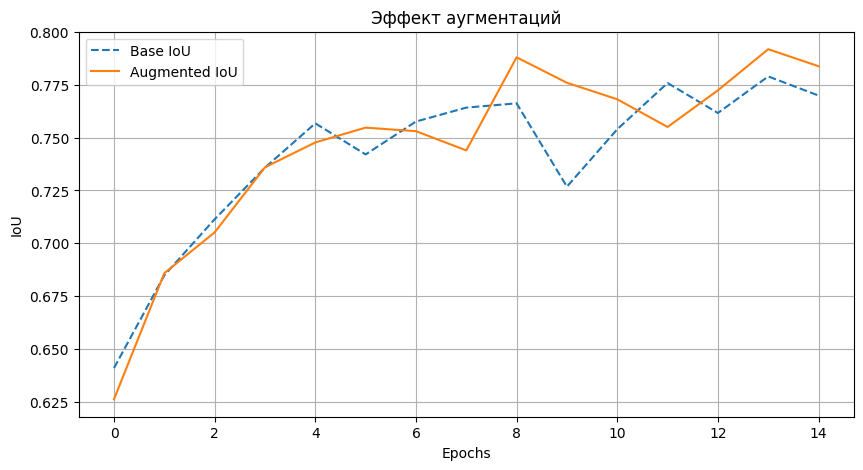

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(unet_history['iou'], '--', label='Base IoU')
plt.plot(unet_aug_history['iou'], label='Augmented IoU')
plt.title('Эффект аугментаций')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.grid()
plt.show()

Видно, что в среднем аугментации незначительно, но улучшили значение IoU метрики модели

## 4.	Имплементация алгоритма машинного обучения

Реализуем свою модель UNet и обучим её на обычном и улучшенном бейзлайнах

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

class CustomUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = ConvBlock(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.bottleneck = ConvBlock(128, 256)
        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = ConvBlock(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = ConvBlock(128, 64)
        self.out = nn.Conv2d(64, 1, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        b = self.bottleneck(p2)
        u1 = self.up1(b)
        u1 = torch.cat([u1, e2], dim=1)
        d1 = self.dec1(u1)
        u2 = self.up2(d1)
        u2 = torch.cat([u2, e1], dim=1)
        d2 = self.dec2(u2)
        out = self.out(d2)
        return self.sigmoid(out)

def calculate_metrics(pred, target):
    pred = pred.cpu().detach().numpy()
    target = target.cpu().detach().numpy()

    iou = jaccard_score(target.flatten(), pred.flatten(), average='macro')
    dice = f1_score(target.flatten(), pred.flatten(), average='macro')
    return iou, dice

custom_model = CustomUNet().to(device)
optimizer_custom = optim.Adam(custom_model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

val_metrics_custom = {'iou': [], 'dice': [], 'loss': []}

for epoch in range(Config.EPOCHS):
    custom_model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer_custom.zero_grad()
        outputs = custom_model(images)
        loss = criterion(outputs.squeeze(1), masks)
        loss.backward()
        optimizer_custom.step()

        running_loss += loss.item()

    custom_model.eval()
    total_iou = 0.0
    total_dice = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = custom_model(images)
            preds = (outputs.squeeze(1) > 0.5).float()

            iou, dice = calculate_metrics(preds, masks)
            total_iou += iou
            total_dice += dice

    avg_loss = running_loss / len(train_loader)
    avg_iou = total_iou / len(val_loader)
    avg_dice = total_dice / len(val_loader)

    val_metrics_custom['loss'].append(avg_loss)
    val_metrics_custom['iou'].append(avg_iou)
    val_metrics_custom['dice'].append(avg_dice)

    print(f'Epoch {epoch+1}/{Config.EPOCHS}')
    print(f'Loss: {avg_loss:.4f}, IoU: {avg_iou:.4f}, Dice: {avg_dice:.4f}')


100%|██████████| 50/50 [00:31<00:00,  1.60it/s]


Epoch 1/15
Loss: 0.4073, IoU: 0.4854, Dice: 0.5898


100%|██████████| 50/50 [00:31<00:00,  1.61it/s]


Epoch 2/15
Loss: 0.3590, IoU: 0.4159, Dice: 0.4543


100%|██████████| 50/50 [00:30<00:00,  1.62it/s]


Epoch 3/15
Loss: 0.3546, IoU: 0.4936, Dice: 0.5980


100%|██████████| 50/50 [00:30<00:00,  1.62it/s]


Epoch 4/15
Loss: 0.3487, IoU: 0.4829, Dice: 0.5685


100%|██████████| 50/50 [00:30<00:00,  1.62it/s]


Epoch 5/15
Loss: 0.3396, IoU: 0.5739, Dice: 0.6964


100%|██████████| 50/50 [00:30<00:00,  1.62it/s]


Epoch 6/15
Loss: 0.3294, IoU: 0.5101, Dice: 0.6054


100%|██████████| 50/50 [00:30<00:00,  1.62it/s]


Epoch 7/15
Loss: 0.3261, IoU: 0.5285, Dice: 0.6302


100%|██████████| 50/50 [00:30<00:00,  1.62it/s]


Epoch 8/15
Loss: 0.3216, IoU: 0.4478, Dice: 0.5095


100%|██████████| 50/50 [00:30<00:00,  1.62it/s]


Epoch 9/15
Loss: 0.3167, IoU: 0.5723, Dice: 0.6925


100%|██████████| 50/50 [00:30<00:00,  1.61it/s]


Epoch 10/15
Loss: 0.3220, IoU: 0.5817, Dice: 0.6965


100%|██████████| 50/50 [00:30<00:00,  1.62it/s]


Epoch 11/15
Loss: 0.3122, IoU: 0.5801, Dice: 0.7091


100%|██████████| 50/50 [00:30<00:00,  1.61it/s]


Epoch 12/15
Loss: 0.3108, IoU: 0.5121, Dice: 0.6037


100%|██████████| 50/50 [00:31<00:00,  1.60it/s]


Epoch 13/15
Loss: 0.3029, IoU: 0.5911, Dice: 0.7172


100%|██████████| 50/50 [00:30<00:00,  1.62it/s]


Epoch 14/15
Loss: 0.3025, IoU: 0.5809, Dice: 0.6924


100%|██████████| 50/50 [00:31<00:00,  1.57it/s]


Epoch 15/15
Loss: 0.3017, IoU: 0.5898, Dice: 0.7007


Значения метрик для реализованной модели на обычном бейзлайне

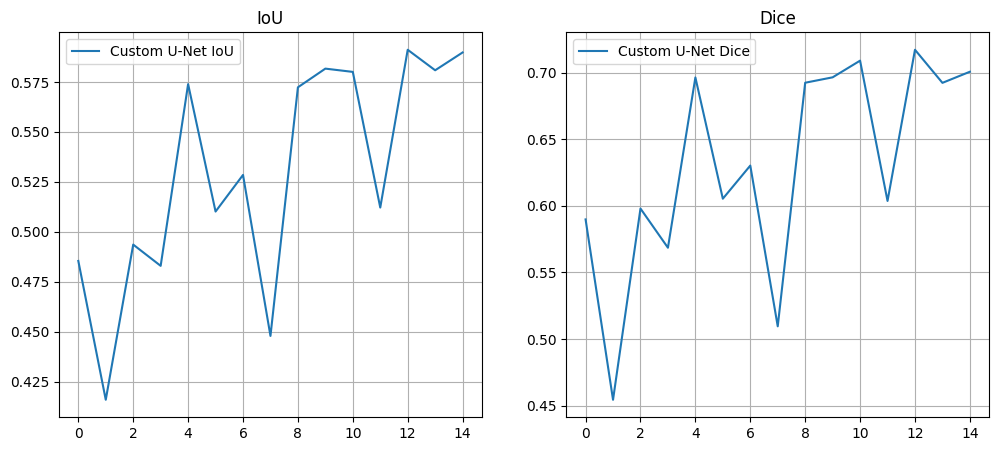

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(val_metrics_custom['iou'], label='Custom U-Net IoU')
plt.title('IoU')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_metrics_custom['dice'], label='Custom U-Net Dice')
plt.title('Dice')
plt.legend()
plt.grid()
plt.show()

In [ ]:
custom_model_aug = CustomUNet().to(device)

optimizer_custom = optim.Adam(custom_model_aug.parameters(), lr=1e-3)
criterion = nn.BCELoss()

val_metrics_custom_aug = {'iou': [], 'dice': [], 'loss': []}

for epoch in range(Config.EPOCHS):
    custom_model_aug.train()
    running_loss = 0.0
    for images, masks in tqdm(train_loader_aug):
        images = images.to(device)
        masks = masks.to(device)

        optimizer_custom.zero_grad()
        outputs = custom_model_aug(images)
        loss = criterion(outputs.squeeze(1), masks)
        loss.backward()
        optimizer_custom.step()

        running_loss += loss.item()

    # Валидация
    custom_model_aug.eval()
    total_iou = 0.0
    total_dice = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = custom_model_aug(images)
            preds = (outputs.squeeze(1) > 0.5).float()

            iou, dice = calculate_metrics(preds, masks)
            total_iou += iou
            total_dice += dice

    avg_loss = running_loss / len(train_loader_aug)
    avg_iou = total_iou / len(val_loader)
    avg_dice = total_dice / len(val_loader)

    val_metrics_custom_aug['loss'].append(avg_loss)
    val_metrics_custom_aug['iou'].append(avg_iou)
    val_metrics_custom_aug['dice'].append(avg_dice)

    print(f'Epoch {epoch+1}/{Config.EPOCHS}')
    print(f'Loss: {avg_loss:.4f}, IoU: {avg_iou:.4f}, Dice: {avg_dice:.4f}')


100%|██████████| 50/50 [00:31<00:00,  1.57it/s]


Epoch 1/15
Loss: 0.4409, IoU: 0.4299, Dice: 0.4799


100%|██████████| 50/50 [00:31<00:00,  1.61it/s]


Epoch 2/15
Loss: 0.3666, IoU: 0.4255, Dice: 0.4732


100%|██████████| 50/50 [00:31<00:00,  1.61it/s]


Epoch 3/15
Loss: 0.3565, IoU: 0.4212, Dice: 0.4643


100%|██████████| 50/50 [00:31<00:00,  1.59it/s]


Epoch 4/15
Loss: 0.3473, IoU: 0.4293, Dice: 0.4788


100%|██████████| 50/50 [00:31<00:00,  1.61it/s]


Epoch 5/15
Loss: 0.3436, IoU: 0.4731, Dice: 0.5513


100%|██████████| 50/50 [00:31<00:00,  1.60it/s]


Epoch 6/15
Loss: 0.3380, IoU: 0.4866, Dice: 0.5727


100%|██████████| 50/50 [00:31<00:00,  1.60it/s]


Epoch 7/15
Loss: 0.3418, IoU: 0.4779, Dice: 0.5673


100%|██████████| 50/50 [00:31<00:00,  1.60it/s]


Epoch 8/15
Loss: 0.3342, IoU: 0.5660, Dice: 0.6867


100%|██████████| 50/50 [00:31<00:00,  1.60it/s]


Epoch 9/15
Loss: 0.3345, IoU: 0.4781, Dice: 0.5577


100%|██████████| 50/50 [00:31<00:00,  1.60it/s]


Epoch 10/15
Loss: 0.3295, IoU: 0.5397, Dice: 0.6457


100%|██████████| 50/50 [00:31<00:00,  1.61it/s]


Epoch 11/15
Loss: 0.3291, IoU: 0.4240, Dice: 0.4694


100%|██████████| 50/50 [00:31<00:00,  1.61it/s]


Epoch 12/15
Loss: 0.3246, IoU: 0.4166, Dice: 0.4556


100%|██████████| 50/50 [00:31<00:00,  1.60it/s]


Epoch 13/15
Loss: 0.3206, IoU: 0.5829, Dice: 0.6969


100%|██████████| 50/50 [00:30<00:00,  1.61it/s]


Epoch 14/15
Loss: 0.3169, IoU: 0.5642, Dice: 0.6728


100%|██████████| 50/50 [00:31<00:00,  1.60it/s]


Epoch 15/15
Loss: 0.3161, IoU: 0.5939, Dice: 0.7142


Сравним значения метрик для реализованной модели на обычном и улучшенном бейзлайнах

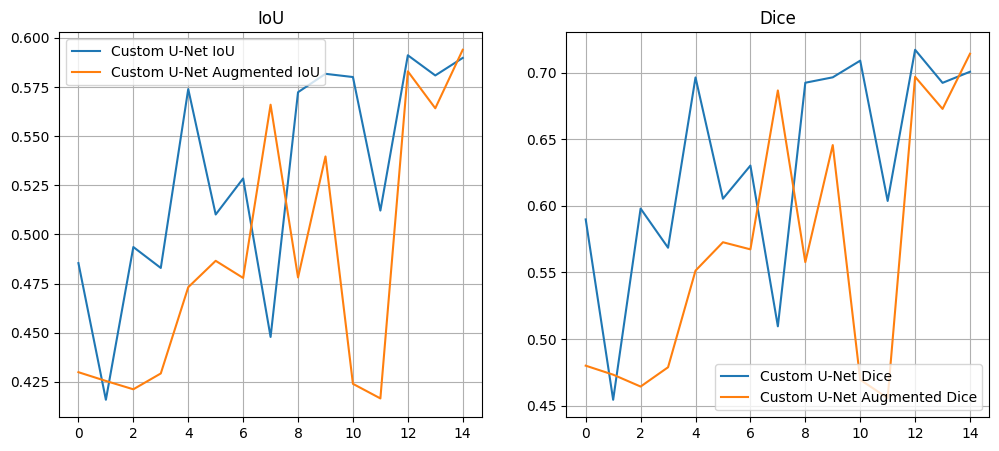

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(val_metrics_custom['iou'], label='Custom U-Net IoU')
plt.plot(val_metrics_custom_aug['iou'], label='Custom U-Net Augmented IoU')
plt.title('IoU')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_metrics_custom['dice'], label='Custom U-Net Dice')
plt.plot(val_metrics_custom_aug['dice'], label='Custom U-Net Augmented Dice')
plt.title('Dice')
plt.legend()
plt.grid()
plt.show()

Видно, что модель оказалась не очень стабильной, однако в целом видно улучшение показателей с увеличением эпох, и под конец модель улучшенного бейзлайна оказалась немного точнее

Проведём сравнение всех моделей, используемых в данной работе:

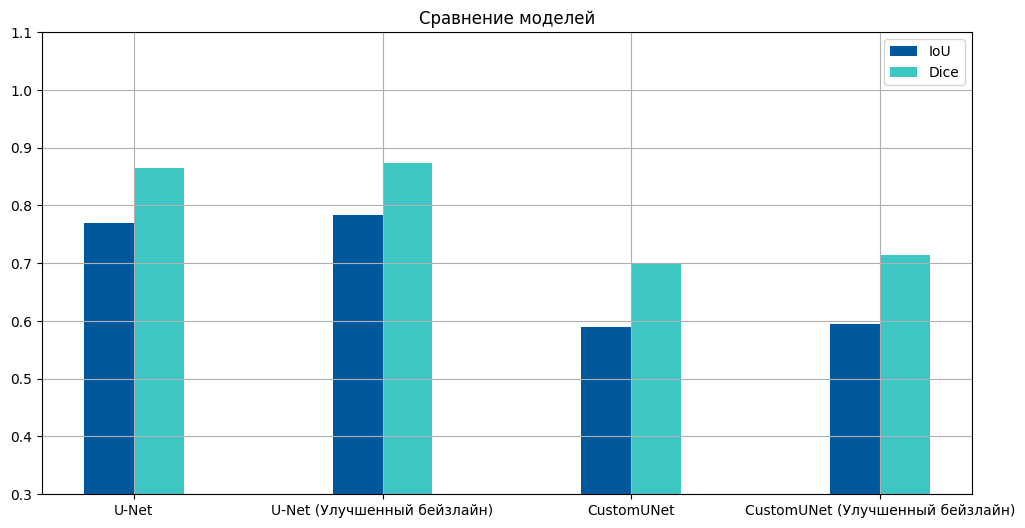

In [ ]:
plt.figure(figsize=(12, 6))
models = ['U-Net', 'U-Net (Улучшенный бейзлайн)', 'CustomUNet', 'CustomUNet (Улучшенный бейзлайн)']
iou_scores = [
    unet_history['iou'][-1],
    unet_aug_history['iou'][-1],
    val_metrics_custom['iou'][-1],
    val_metrics_custom_aug['iou'][-1]
]

dice_scores = [
    unet_history['dice'][-1],
    unet_aug_history['dice'][-1],
    val_metrics_custom['dice'][-1],
    val_metrics_custom_aug['dice'][-1]
]

x = np.arange(len(models))
plt.bar(x - 0.1, iou_scores, 0.2, label='IoU', color='#00589C')
plt.bar(x + 0.1, dice_scores, 0.2, label='Dice', color='#3DC6C3')
plt.xticks(x, models)
plt.title('Сравнение моделей')
plt.ylim(0.3, 1.1)
plt.legend()
plt.grid()
plt.show()

## Вывод

В ходе работы были исследованы модели из segmentation_models.pytorch, решающие задачу семантической сегментации. Значения метрик IoU и Dice для всех исследованных моделей приведены в таблице:

| Модель                           | IoU      |  Dice  |
|----------------------------------|----------|--------|
| UNet                             |  0.7699  | 0.8646 |
| DeepLabV3+                       |  0.7681  | 0.8631 |
| UNet (улучшенный бейзлайн)       |  0.7837  | 0.8727 |
| CustomUNet                       |  0.5898  | 0.7007 |
| CustomUNet (улучшенный бейзлайн) |  0.5939  | 0.7142 |

Имплементированные модели показали неплохие значение метрик, хоть и оказались менее точными, чем библиотечные версии. Улучшение бейзлайна привело к улучшению метрик всех исследуемых моделей, хоть и не очень значительным.